# Assignment 2.

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdataanalysis2020/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday March 30th, 2020 at 23:55. Hand in your files via [`http://peergrade.io`](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 6 days to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Sunday April 5th, 2020 at 23:55. (The reason I'm asking you to do the peer evaluations on the sunday is that I want you to be able to enjoy the easter break fully.)

## Part 1: Questions to text and lectures.

A) Please answer my questions to the Segal and Heer paper we read during lecture 7 and 8.

* What is the *Oxford English Dictionary's* defintion of a narrative?
* What is your favorite visualization among the examples in section 3? Explain why in a few words.
* What's the point of Figure 7?
* Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure (the categories within visual narrative are 'visual structuring', 'highlighting', etc).
* Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?


B) Also please answer the questions to my talk on [explanatory data visualization](https://www.youtube.com/watch?v=yHKYMGwefso)

* What are the three key elements to keep in mind when you design an explanatory visualization?
* In the video I talk about (1) *overview first*,  (2) *zoom and filter*,  (3) *details on demand*. 
  - Go online and find a visualization that follows these principles (don't use one from the video). 
  - Explain how it does achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.
* Explain in your own words: How is explanatory data analysis different from exploratory data analysis?

In [410]:
import numpy as np
import pandas as pd
import folium
import imageio
import matplotlib
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from graphviz import Source
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [411]:
crimedata = pd.read_csv("../../../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
crimedata.Date = pd.to_datetime(crimedata.Date)
crimedata['Hour'] = pd.to_datetime(crimedata.Time).dt.hour
crimedata['DayOfWeek'] = crimedata.Date.dt.dayofweek
crimedata['Month'] = crimedata.Date.dt.month
crimedata['Minutes'] = pd.to_datetime(crimedata.Time).dt.minute
crimedata['Year'] = crimedata.Date.dt.year
crimedata['X'] = crimedata['X'].astype(float)
crimedata['Y'] = crimedata['Y'].astype(float)

In [412]:
crimedata.head()

IncidntNum         Category                               Descript  \
0   110308742   MISSING PERSON                           FOUND PERSON   
1    90316914         WARRANTS                         WARRANT ARREST   
2   130132311  SECONDARY CODES                      DOMESTIC VIOLENCE   
3    80052833   OTHER OFFENSES  DRIVERS LICENSE, SUSPENDED OR REVOKED   
4    70535770  SECONDARY CODES                      DOMESTIC VIOLENCE   

   DayOfWeek       Date   Time PdDistrict      Resolution  \
0          4 2011-04-15  16:00    TARAVAL         LOCATED   
1          3 2009-03-26  12:28   SOUTHERN  ARREST, BOOKED   
2          4 2013-02-15  02:00       PARK  ARREST, BOOKED   
3          1 2008-01-15  20:13    MISSION   ARREST, CITED   
4          5 2007-05-26  18:10    MISSION  ARREST, BOOKED   

                   Address           X          Y  \
0     0 Block of CRESPI DR -122.476328  37.719687   
1  1000 Block of MARKET ST -122.411340  37.781271   
2    CASTRO ST / MARKET ST -122.435188  37.762670   
3    VALENCIA ST / 16TH ST -122.421886  37.764918   
4  2800 Block of FOLSOM ST -122.413935  37.751693   

                                     Location            PdId  Hour  Month  \
0  POINT (-122.476327815126 37.7196874952717)  11030874275000    16      4   
1  POINT (-122.411339562557 37.7812707434494)   9031691463010    12      3   
2  POINT (-122.435187699349 37.7626702770872)  13013231115200     2      2   
3  POINT (-122.421886357981 37.7649178909424)   8005283365016    20      1   
4  POINT (-122.413935404044 37.7516932889916)   7053577015200    18      5   

   Minutes  Year  
0        0  2011  
1       28  2009  
2        0  2013  
3       13  2008  
4       10  2007

Removing NaN values from the dataset

In [413]:
#Check and remove missing values
is_NaN = crimedata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = crimedata[row_has_NaN]
print(f"{len(rows_with_NaN)} row(s) with NaN values deleted")
crimedata = crimedata.drop(rows_with_NaN.index)

1 row(s) with NaN values deleted


## Part 2: Random forest and weather

The aim here is to recreate the work you did in Part 1 and 2 of the Week 7 lecture. I've phrased things differently relative to the exercise to make the purpose more clear. 

Part 2A: Random forest binary classification. 
* Using the and instructions and material from Week 7, build a *random forest* classifier to distinguish between two types (you choose) of crime using on spatio-temporal (where/when) features of data describing the two crimes. When you're done, you should be able to give the classifier a place and a time, and it should tell you which of the two  types of crime happened there.
  - Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))
  - Report accuracy. Discuss the model performance.

In [414]:
# Create a column for Hour of the week
crimedata['HourOfTheWeek'] = crimedata.Hour + (crimedata.DayOfWeek) * 24

#### Encoding
**PdDistrict** has been encoded into a one-hot encoding. This is due to its nature not having an ordinal relationship between values. Prediction models could mistakenly use this relationship in their prediction and this is something to avoid since there is no order in the districts. One hot encoding solves this by creating a binary column for each value of that feature.

In [415]:
#One Hot Encode PdDistrict
crimedata.PdDistrict = pd.Categorical(crimedata['PdDistrict'])
pddummies = pd.get_dummies(crimedata['PdDistrict'], prefix = 'pddistrict')
pd_columns = list(pddummies.columns.values)

# Concat new hot encoded columns and the other columns
dataencoded = pd.concat([crimedata, pddummies], axis=1)
dataencoded.head()

IncidntNum         Category                               Descript  \
0   110308742   MISSING PERSON                           FOUND PERSON   
1    90316914         WARRANTS                         WARRANT ARREST   
2   130132311  SECONDARY CODES                      DOMESTIC VIOLENCE   
3    80052833   OTHER OFFENSES  DRIVERS LICENSE, SUSPENDED OR REVOKED   
4    70535770  SECONDARY CODES                      DOMESTIC VIOLENCE   

   DayOfWeek       Date   Time PdDistrict      Resolution  \
0          4 2011-04-15  16:00    TARAVAL         LOCATED   
1          3 2009-03-26  12:28   SOUTHERN  ARREST, BOOKED   
2          4 2013-02-15  02:00       PARK  ARREST, BOOKED   
3          1 2008-01-15  20:13    MISSION   ARREST, CITED   
4          5 2007-05-26  18:10    MISSION  ARREST, BOOKED   

                   Address           X  ...  pddistrict_BAYVIEW  \
0     0 Block of CRESPI DR -122.476328  ...                   0   
1  1000 Block of MARKET ST -122.411340  ...                   0   
2    CASTRO ST / MARKET ST -122.435188  ...                   0   
3    VALENCIA ST / 16TH ST -122.421886  ...                   0   
4  2800 Block of FOLSOM ST -122.413935  ...                   0   

  pddistrict_CENTRAL  pddistrict_INGLESIDE  pddistrict_MISSION  \
0                  0                     0                   0   
1                  0                     0                   0   
2                  0                     0                   0   
3                  0                     0                   1   
4                  0                     0                   1   

   pddistrict_NORTHERN  pddistrict_PARK  pddistrict_RICHMOND  \
0                    0                0                    0   
1                    0                0                    0   
2                    0                1                    0   
3                    0                0                    0   
4                    0                0                    0   

   pddistrict_SOUTHERN  pddistrict_TARAVAL  pddistrict_TENDERLOIN  
0                    0                   1                      0  
1                    1                   0                      0  
2                    0                   0                      0  
3                    0                   0                      0  
4                    0                   0                      0  

[5 rows x 28 columns]

In [416]:
#filter the columns to use to fit the classifier from data
# will keep Date and Hour for weather data exercise
datacols = ['Date', 'Hour','HourOfTheWeek', 'X', 'Y', 'Category']
datacols += pd_columns
dtcrimedata = dataencoded[datacols]
dtcrimedata

Date  Hour  HourOfTheWeek           X          Y  \
0       2011-04-15    16            112 -122.476328  37.719687   
1       2009-03-26    12             84 -122.411340  37.781271   
2       2013-02-15     2             98 -122.435188  37.762670   
3       2008-01-15    20             44 -122.421886  37.764918   
4       2007-05-26    18            138 -122.413935  37.751693   
...            ...   ...            ...         ...        ...   
2215019 2006-10-09    19             19 -122.405602  37.777265   
2215020 2013-04-30    23             47 -122.419699  37.752951   
2215021 2003-01-29    13             61 -122.402210  37.728104   
2215022 2004-02-13    16            112 -122.402219  37.795713   
2215023 2010-08-24    14             38 -122.419877  37.769580   

                Category  pddistrict_BAYVIEW  pddistrict_CENTRAL  \
0         MISSING PERSON                   0                   0   
1               WARRANTS                   0                   0   
2        SECONDARY CODES                   0                   0   
3         OTHER OFFENSES                   0                   0   
4        SECONDARY CODES                   0                   0   
...                  ...                 ...                 ...   
2215019   MISSING PERSON                   0                   0   
2215020    VEHICLE THEFT                   0                   0   
2215021   OTHER OFFENSES                   1                   0   
2215022    LARCENY/THEFT                   0                   1   
2215023   OTHER OFFENSES                   0                   0   

         pddistrict_INGLESIDE  pddistrict_MISSION  pddistrict_NORTHERN  \
0                           0                   0                    0   
1                           0                   0                    0   
2                           0                   0                    0   
3                           0                   1                    0   
4                           0                   1                    0   
...                       ...                 ...                  ...   
2215019                     0                   0                    0   
2215020                     0                   1                    0   
2215021                     0                   0                    0   
2215022                     0                   0                    0   
2215023                     0                   1                    0   

         pddistrict_PARK  pddistrict_RICHMOND  pddistrict_SOUTHERN  \
0                      0                    0                    0   
1                      0                    0                    1   
2                      1                    0                    0   
3                      0                    0                    0   
4                      0                    0                    0   
...                  ...                  ...                  ...   
2215019                0                    0                    1   
2215020                0                    0                    0   
2215021                0                    0                    0   
2215022                0                    0                    0   
2215023                0                    0                    0   

         pddistrict_TARAVAL  pddistrict_TENDERLOIN  
0                         1                      0  
1                         0                      0  
2                         0                      0  
3                         0                      0  
4                         0                      0  
...                     ...                    ...  
2215019                   0                      0  
2215020                   0                      0  
2215021                   0                      0  
2215022                   0                      0  
2215023                   0                      0  

[2215023 rows x 16 columns]

The crimes picked for training and prediction are: 
- **BURGLARY**: as a crime influenced by the weather. When there is bad weather people may tend to stay home and burglaries often happen when people are not home
- **FRAUD**: as a crime NOT influenced by the weather. It does not seem to be a reasonable connection between weather and this crime

In [417]:
crime1 = "BURGLARY"
crime2 = "FRAUD"

In [418]:
print(f"Dataset size for category {crime1}: {len(dtcrimedata[dtcrimedata.Category == crime1])}")
print(f"Dataset size for category {crime2}: {len(dtcrimedata[dtcrimedata.Category == crime2])}")

Dataset size for category BURGLARY: 91543
Dataset size for category FRAUD: 41542


### Feature analysis
We are going to analyze the different spatial/temporal attributes to highlight possible ones which differentiate the two crimes and could therefore be included in the classifier training.

In [419]:
def plot_feature(data, feature, crimes, figsize=(15,5)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    #fig.suptitle("Hour")
    for i, crime in enumerate(crimes):
        axi=axes[i]
        axi.set_title(crime, y=0.80)
        axi.margins(y=0.3)
        axi.set_ylabel('Crimes')
        data[(data.Category == crime)]\
        .groupby(feature).count().IncidntNum\
        .plot(ax=axi, kind='bar')
        if feature == "HourOfTheWeek":
            axi.set_xlabel("Hour of the day throughout the week (Days start at 12 AM)")
            bars = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday')
            y_pos = (0, 24, 48, 72, 96, 120, 144)
            axi.set_xticks(y_pos)
            axi.set_xticklabels(bars)
            axi.tick_params(axis='x', which="minor",length=0)

#### X and Y features

In [420]:
def plot_heat_crimes(title, data):
    mapsf = folium.Map(name=title, location=[37.763972, -122.431297], zoom_start = 12)
    heat_data = [[row.Y,row.X] for index, row in data.iterrows()]
    HeatMap(heat_data, radius=10, max_zoom=20).add_to(mapsf)
    return mapsf

In [421]:
print(f"Heatmap for {crime1}")

Heatmap for BURGLARY


In [422]:
plot_heat_crimes(crime1, crimedata[crimedata.Category == crime1])

In [423]:
print(f"Heatmap for {crime2}")

Heatmap for FRAUD


In [424]:
plot_heat_crimes(crime2, crimedata[crimedata.Category == crime2])

#### Hour of the day

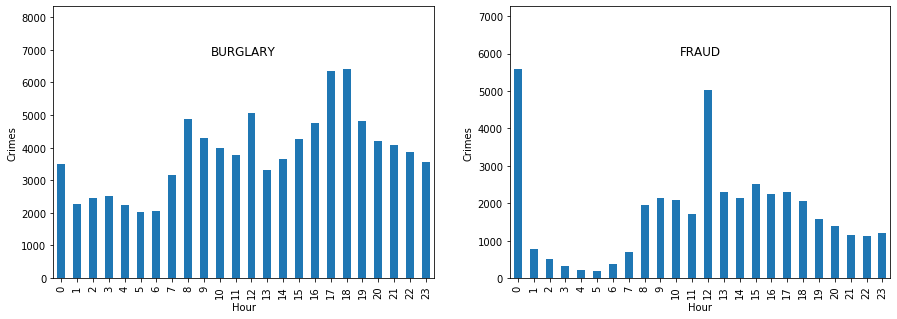

In [425]:
plot_feature(crimedata, "Hour", [crime1, crime2])

#### Hour of the week

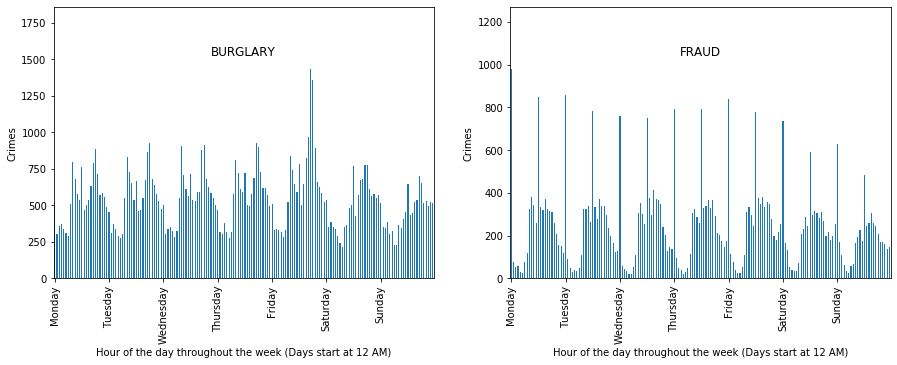

In [426]:
plot_feature(crimedata, "HourOfTheWeek", [crime1, crime2])

#### Day of the week

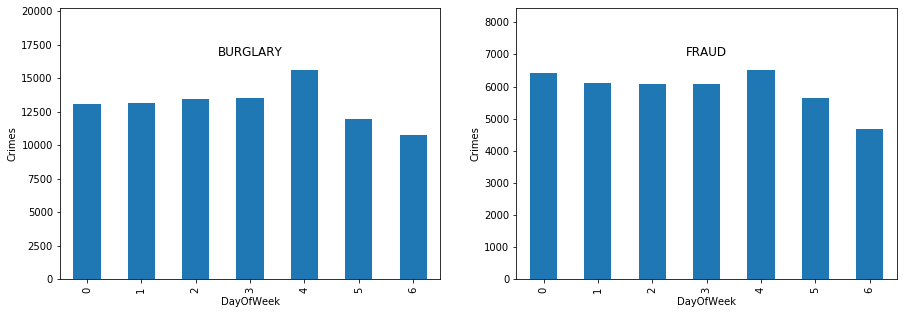

In [427]:
plot_feature(crimedata, "DayOfWeek", [crime1, crime2])

#### Month

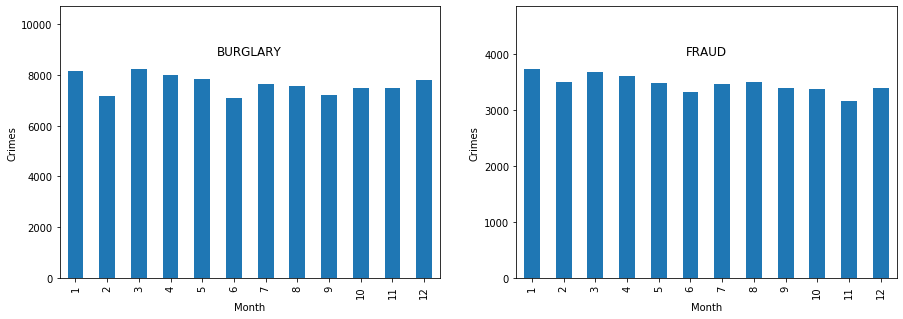

In [428]:
plot_feature(crimedata, "Month", [crime1, crime2])

#### PD District

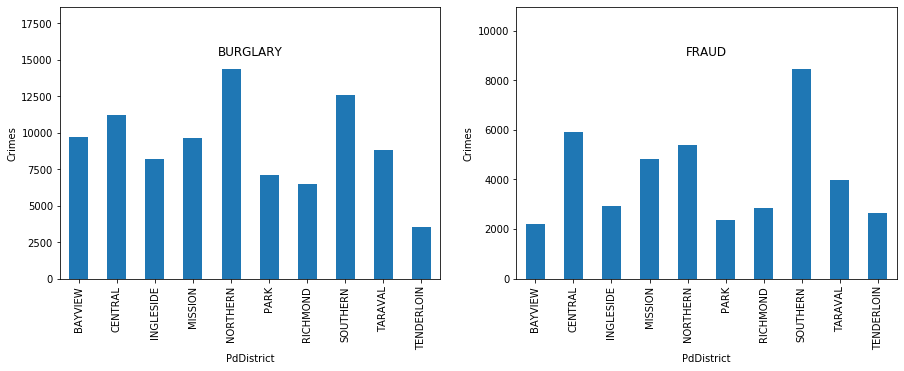

In [429]:
plot_feature(crimedata, "PdDistrict", [crime1, crime2])

#### Conclusions
From these informal visualizations we can conclude that the most informative features are HourOfTheWeek and Hour (which share some common data since HourOfTheWeek is also based on Hour), along with PdDistrict that also shows some interesting differences for the two crimes as well. Longitude and Latitude (X and Y) also show different behaviors and could be usefult to include them as well. The other features show a similar patterns for both crimes and should not help the classifier in correctly predict the crimes.

### Fitting functions

In [431]:
def fit_and_predict(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=5)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    return y_test, y_predict

In [432]:
def fit_and_predict_training_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=5)
    clf.fit(X_train, y_train)
    y_train_predict = clf.predict(X_train)
    return y_train, y_train_predict

In [433]:
def predict_confusion_matrix(columns_to_drop, dataset, crime1, crime2, title, ax=None):
    y = dataset.Category
    X = dataset.drop(columns_to_drop, axis=1)
    y_test, y_predict = fit_and_predict(X, y)
    print_confusion_matrix(title, y_test, y_predict, crime1, crime2, ax=ax)
    return y_test, y_predict

In [453]:
def print_confusion_matrix(title, y_test, y_predict, crime1, crime2, ax=None):
    cf_matrix = confusion_matrix(y_test, y_predict)
    group_names = [f"True {crime1}",f"False {crime1}",f"False {crime2}",f"True {crime2}"]
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    if not ax:
        ax =  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        ax =  sns.heatmap(cf_matrix, annot=labels, ax=ax, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title(title)

### Balancing the dataset

In [430]:
#Sample balanced dataset
samplesizepercat = min(len(dtcrimedata[dtcrimedata.Category == crime1]),len(dtcrimedata[dtcrimedata.Category == crime2]))

crime1sample = dtcrimedata[dtcrimedata.Category == crime1].sample(n=samplesizepercat)
crime2sample = dtcrimedata[dtcrimedata.Category == crime2].sample(n=samplesizepercat)

balanceddataset = pd.concat([crime1sample, crime2sample])

### Testing feature sets
We will test the different combinations of relevant features from the ones identified in the previous section.<br/>
This will allow us to find the best performing combination of features for our model

In [435]:
#Feature to predict
y = balanceddataset.Category

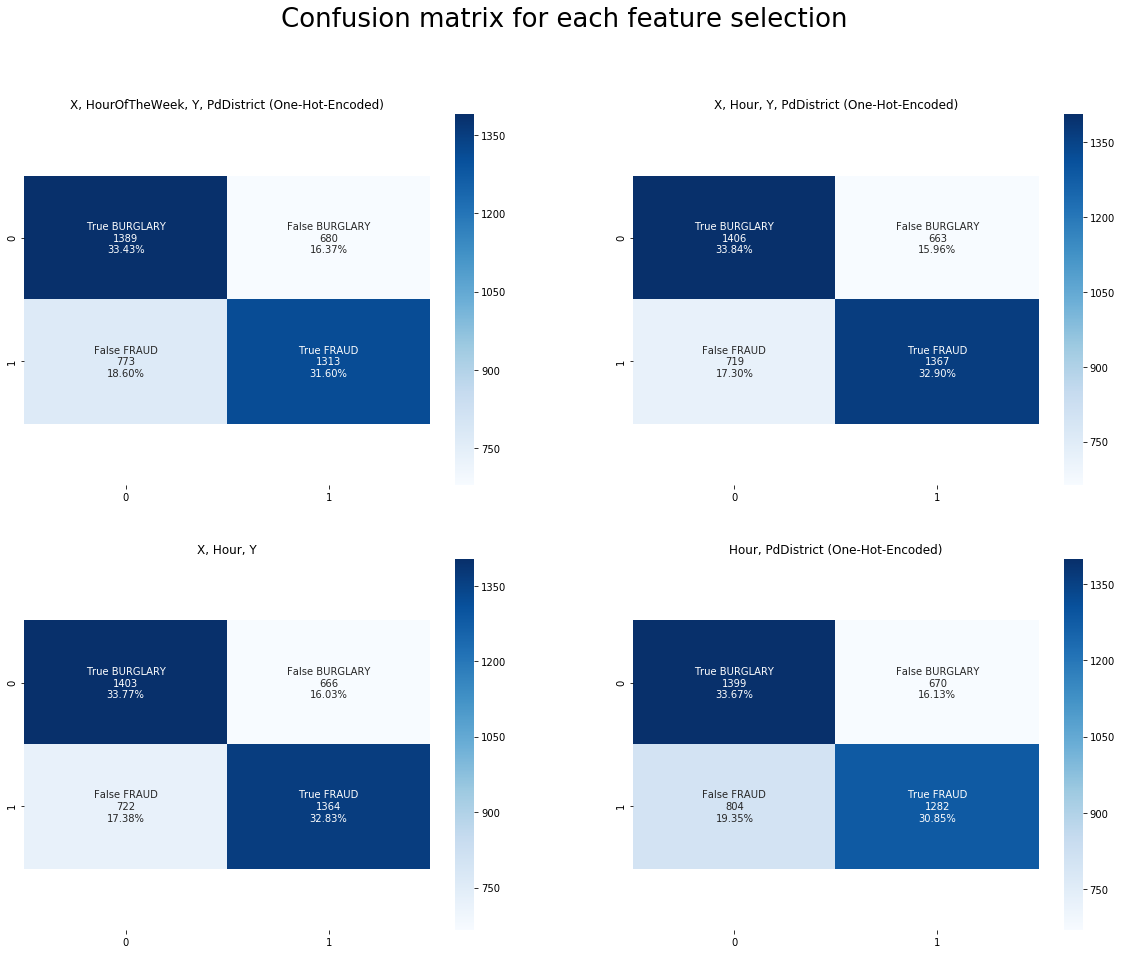

In [436]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
fig.suptitle('Confusion matrix for each feature selection', fontsize=26)
predict_confusion_matrix(['Date', 'Hour', 'Category'], balanceddataset, crime1, crime2, ', '.join(['X', 'HourOfTheWeek', 'Y', 'PdDistrict (One-Hot-Encoded)']), ax=axes[0][0])
y_test, y_predict = predict_confusion_matrix(['Date', 'HourOfTheWeek', 'Category'], balanceddataset, crime1, crime2, ', '.join(['X', 'Hour', 'Y', 'PdDistrict (One-Hot-Encoded)']), ax=axes[0][1])
predict_confusion_matrix(['Date', 'HourOfTheWeek', 'Category'] + pd_columns, balanceddataset, crime1, crime2, ', '.join(['X', 'Hour', 'Y']), ax=axes[1][0])
predict_confusion_matrix(['Date', 'HourOfTheWeek','X', 'Y', 'Category'], balanceddataset, crime1, crime2, ', '.join(['Hour', 'PdDistrict (One-Hot-Encoded)']), ax=axes[1][1])
plt.show()

We focused on the following features that were showing different patterns for the two crimes:
- ****Hour****
- ****PdDistrict****
- ****X****
- ****Y****
- ****Hour of the week****

We then fitted the Random forest on a combination of those to evaluate the best performing one.
The confusion matrix showed that using only the ****Hour**** feature and not including ****HourOfTheWeek**** provides better results. <br/> It also shows that including both the coordinates ****X,Y and the PdDistrict**** slightly improves the performance of the model compared to only using ****X and Y****. <br/>
It may be thought that PdDistrict is irrelevant if X and Y coordinate are in the model. This is however not the case, as we evaluated both options and the one including both was performing slightly better. This could be due to different patterns at district levels and within the district, the X and Y coordinate allow the model to further and more precisely differentiate the two crimes having different X,Y patterns within the district.<br/>
Our feature selection resulted therefore in: ****Hour****, ****PdDistrict****, ****X**** and ****Y****.<br/>

### Performance of the selected model

We now show the exact performance of our model with the features:
- ****Hour****
- ****PdDistrict****
- ****X****
- ****Y****

In [437]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.66      0.68      0.67      2069
       FRAUD       0.67      0.66      0.66      2086

    accuracy                           0.67      4155
   macro avg       0.67      0.67      0.67      4155
weighted avg       0.67      0.67      0.67      4155



The classification performance are very similar for both crimes. This is expected given the balanced dataset. The model has a precision of 0.67 and 0.69 for the two crimes. This means that there is almost a 70% chances that the the predicted crime is the correct one (that is a "True positive" out of all the ones categorized as positive. In our case positive is one crime and negative the other one). Recall is also similar for both crimes: this means that our of all the observations of one specific crime, 70% are predicted correctly. This is a result which is much better than the baseline which is 50%: guessing randomly between the two crimes.

#### Overfitting
In order to assess whether the classifier overfits the training set, we can compare the performance of the classifier on the training data and on the test data. Ideally we would get the same (high) prediction results on both the datasets.

In [438]:
# Extract X features and y column
y = balanceddataset.Category
X = balanceddataset.drop(['Date', 'HourOfTheWeek', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")

Columns used: ['Hour' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


##### Results of prediction on training data

In [439]:
y_train, y_train_predict = fit_and_predict_training_data(X, y)
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

    BURGLARY       0.94      0.91      0.92     39473
       FRAUD       0.92      0.94      0.93     39456

    accuracy                           0.93     78929
   macro avg       0.93      0.93      0.93     78929
weighted avg       0.93      0.93      0.93     78929



##### Results of prediction on test data

In [440]:
y_test, y_predict = fit_and_predict(X, y)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.66      0.68      0.67      2069
       FRAUD       0.67      0.66      0.66      2086

    accuracy                           0.67      4155
   macro avg       0.67      0.67      0.67      4155
weighted avg       0.67      0.67      0.67      4155



The results show a **possible overfitting**. This could be resolved by increasing the dataset size or with cross validation

### Unbalanced dataset performance
Giving the optimal feature selection from the previous section, we test the perfomance on the unbalanced dataset

In [441]:
#Create the unbalanced dataset
crime1sample = dtcrimedata[dtcrimedata.Category == crime1]
crime2sample = dtcrimedata[dtcrimedata.Category == crime2]

unbalanceddataset = pd.concat([crime1sample, crime2sample])

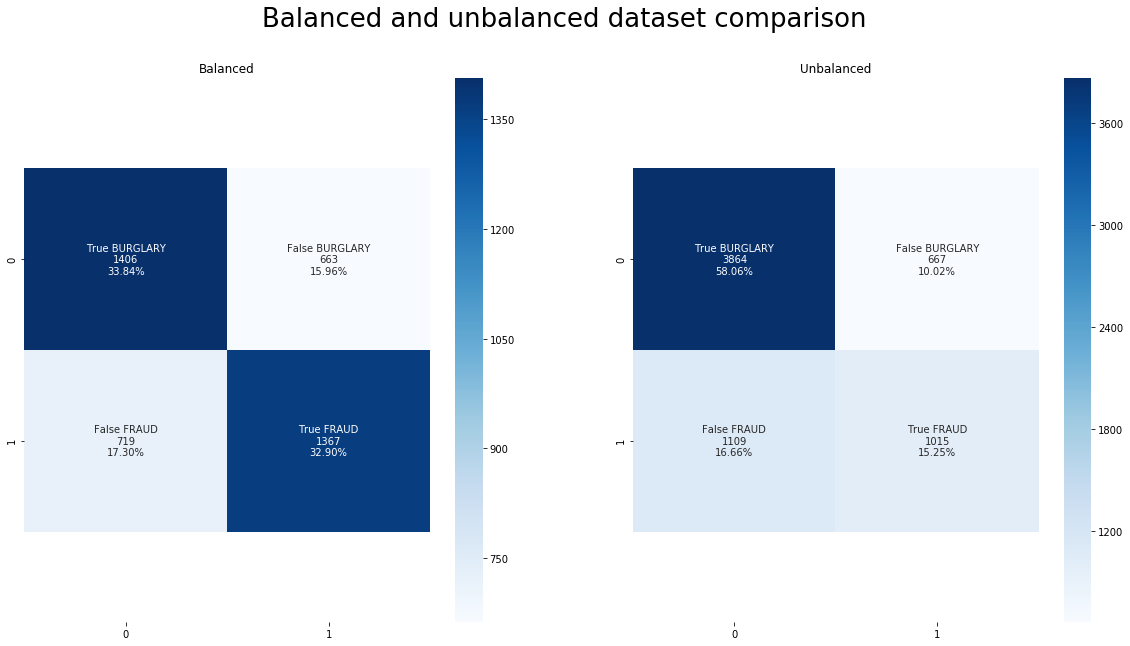

In [442]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.suptitle('Balanced and unbalanced dataset comparison', fontsize=26)
predict_confusion_matrix(['Date', 'HourOfTheWeek', 'Category'], balanceddataset, crime1, crime2, "Balanced", ax=axes[0])
#Test unbalanced and save results for future analysis
y_test, y_predict = predict_confusion_matrix(['Date', 'HourOfTheWeek', 'Category'], unbalanceddataset, crime1, crime2, "Unbalanced", ax=axes[1])

In [443]:
print("Unbalanced performance:")
print(classification_report(y_test, y_predict))

Unbalanced performance:
              precision    recall  f1-score   support

    BURGLARY       0.78      0.85      0.81      4531
       FRAUD       0.60      0.48      0.53      2124

    accuracy                           0.73      6655
   macro avg       0.69      0.67      0.67      6655
weighted avg       0.72      0.73      0.72      6655



As it can be seen in this section, the classifier trained on the unbalanced dataset predicts much better the most predominant category. This is due to the bigger proportion of observations in the dataset from that category - which leads to a more precise classifier (more data to learn from), and a general tendency for the model to predict many more new observations as belonging to that category since this will often be the right answer. We opted for a balanced dataset which provides almost the same classification result (f1 score among the others) for both categories. This way the classifier learns to classify the categories based on their differencies in behaviors and patterns rather than preferring one over the other due to a larger probability of guessing correctly.

## Part 2B: Info from weather features.
* Now add features from weather data to your random forest. 
  - Report accuracy. 
  - Discuss how the model performance changes relative to the version with no weather data.
  - Discuss what you have learned about crime from including weather data in your model.

In [444]:
#Import data
weather_data = pd.read_csv("../../../weather_data.txt")
weather_data.date = pd.to_datetime(weather_data.date)
weather_data

date  temperature  humidity       weather  \
0     2012-10-01 13:00:00+00:00    16.330000      88.0    light rain   
1     2012-10-01 14:00:00+00:00    16.324993      87.0  sky is clear   
2     2012-10-01 15:00:00+00:00    16.310618      86.0  sky is clear   
3     2012-10-01 16:00:00+00:00    16.296243      85.0  sky is clear   
4     2012-10-01 17:00:00+00:00    16.281869      84.0  sky is clear   
...                         ...          ...       ...           ...   
44301 2017-10-27 20:00:00+00:00    23.910000      28.0  sky is clear   
44302 2017-10-27 21:00:00+00:00    25.990000      25.0  sky is clear   
44303 2017-10-27 22:00:00+00:00    27.410000      22.0  sky is clear   
44304 2017-10-27 23:00:00+00:00    27.910000      20.0  sky is clear   
44305 2017-10-28 00:00:00+00:00    28.920000      22.0  sky is clear   

       wind_speed  wind_direction  pressure  
0             2.0           150.0    1009.0  
1             2.0           147.0    1009.0  
2             2.0           141.0    1009.0  
3             2.0           135.0    1009.0  
4             2.0           129.0    1009.0  
...           ...             ...       ...  
44301         0.0           277.0    1015.0  
44302         2.0             0.0    1014.0  
44303         2.0             0.0    1014.0  
44304         2.0           120.0    1013.0  
44305         2.0           130.0    1013.0  

[44306 rows x 7 columns]

In [445]:
#Check and remove missing values
is_NaN = weather_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = weather_data[row_has_NaN]
print(f"{len(rows_with_NaN)} rows removed")
weather_data = weather_data.drop(rows_with_NaN.index)

2 rows removed


In [454]:
#Format date column in the same way. Needed for merging
balanced_formatted = balanceddataset.copy()
balanced_formatted['date'] = balanced_formatted.Date +  pd.to_timedelta(balanced_formatted.Hour, unit='h')
balanced_formatted['date'] = pd.to_datetime(balanced_formatted["date"].dt.strftime('%B %d, %Y, %r'))
weather_data['date'] = pd.to_datetime(weather_data["date"].dt.strftime('%B %d, %Y, %r'))

### Merging the two datasets

In [447]:
#Merge the two datasets
crimeweather = pd.merge(balanced_formatted, weather_data, on='date', how="inner")

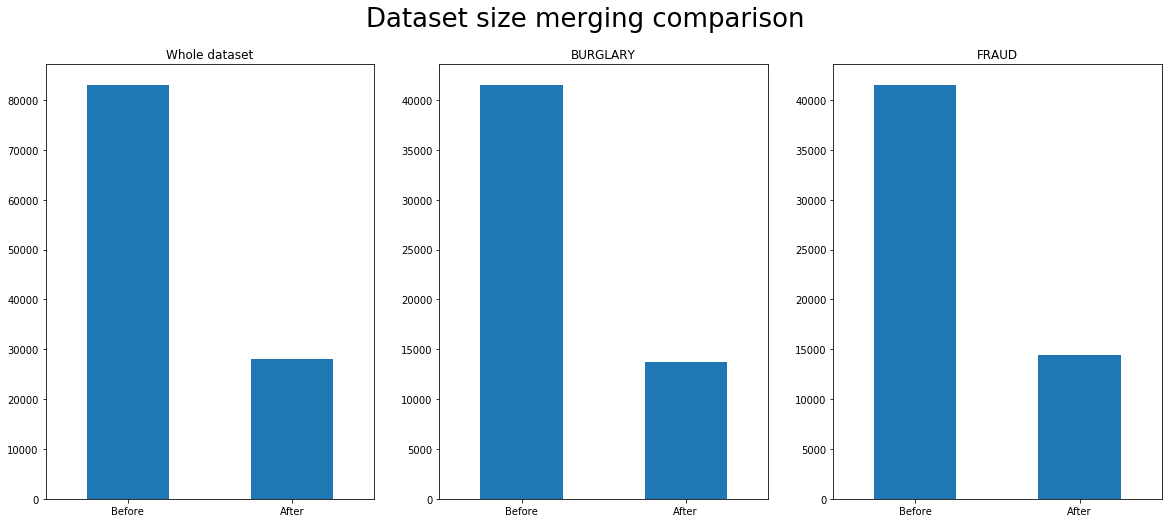

In [457]:
sizediffer = pd.Series(np.array([len(balanced_formatted), len(crimeweather)]), index=["Before", "After"])
crime1differ = pd.Series(np.array([len(balanced_formatted[balanced_formatted.Category == crime1]), len(crimeweather[crimeweather.Category == crime1])]), index=["Before", "After"])
crime2differ = pd.Series(np.array([len(balanced_formatted[balanced_formatted.Category == crime2]), len(crimeweather[crimeweather.Category == crime2])]), index=["Before", "After"])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
fig.suptitle('Dataset size merging comparison', fontsize=26)
sizediffer.plot(kind="bar", title="Whole dataset", ax=axes[0])
crime1differ.plot(kind="bar", title=f"{crime1}", ax=axes[1])
crime2differ.plot(kind="bar", title=f"{crime2}", ax=axes[2])
for i in range(0,3):
    axes[i].tick_params(axis='x', labelrotation=0)

We one-hot-encode the ****Weather**** feature since it is categorical and has no ordinal relationships between its values.

In [449]:
#One hot encode weather column
weatherdummies = pd.get_dummies(crimeweather.weather, prefix = 'weather')
crimeweather = pd.concat([crimeweather.drop(["weather"], axis=1), weatherdummies], axis=1)
crimeweather = crimeweather.drop(['Date', 'date', 'HourOfTheWeek'], axis=1)
crimeweather.columns.values

array(['Hour', 'X', 'Y', 'Category', 'pddistrict_BAYVIEW',
       'pddistrict_CENTRAL', 'pddistrict_INGLESIDE', 'pddistrict_MISSION',
       'pddistrict_NORTHERN', 'pddistrict_PARK', 'pddistrict_RICHMOND',
       'pddistrict_SOUTHERN', 'pddistrict_TARAVAL',
       'pddistrict_TENDERLOIN', 'temperature', 'humidity', 'wind_speed',
       'wind_direction', 'pressure', 'weather_broken clouds',
       'weather_drizzle', 'weather_few clouds', 'weather_fog',
       'weather_haze', 'weather_heavy intensity drizzle',
       'weather_heavy intensity rain', 'weather_heavy snow',
       'weather_light intensity drizzle',
       'weather_light intensity shower rain', 'weather_light rain',
       'weather_light snow', 'weather_mist', 'weather_moderate rain',
       'weather_overcast clouds', 'weather_proximity shower rain',
       'weather_proximity thunderstorm',
       'weather_proximity thunderstorm with rain',
       'weather_scattered clouds', 'weather_shower rain',
       'weather_sky is clear

### Testing weather features
As we did previously, we test the performance on subsets (or all) of the available features to evaluate the best performing one

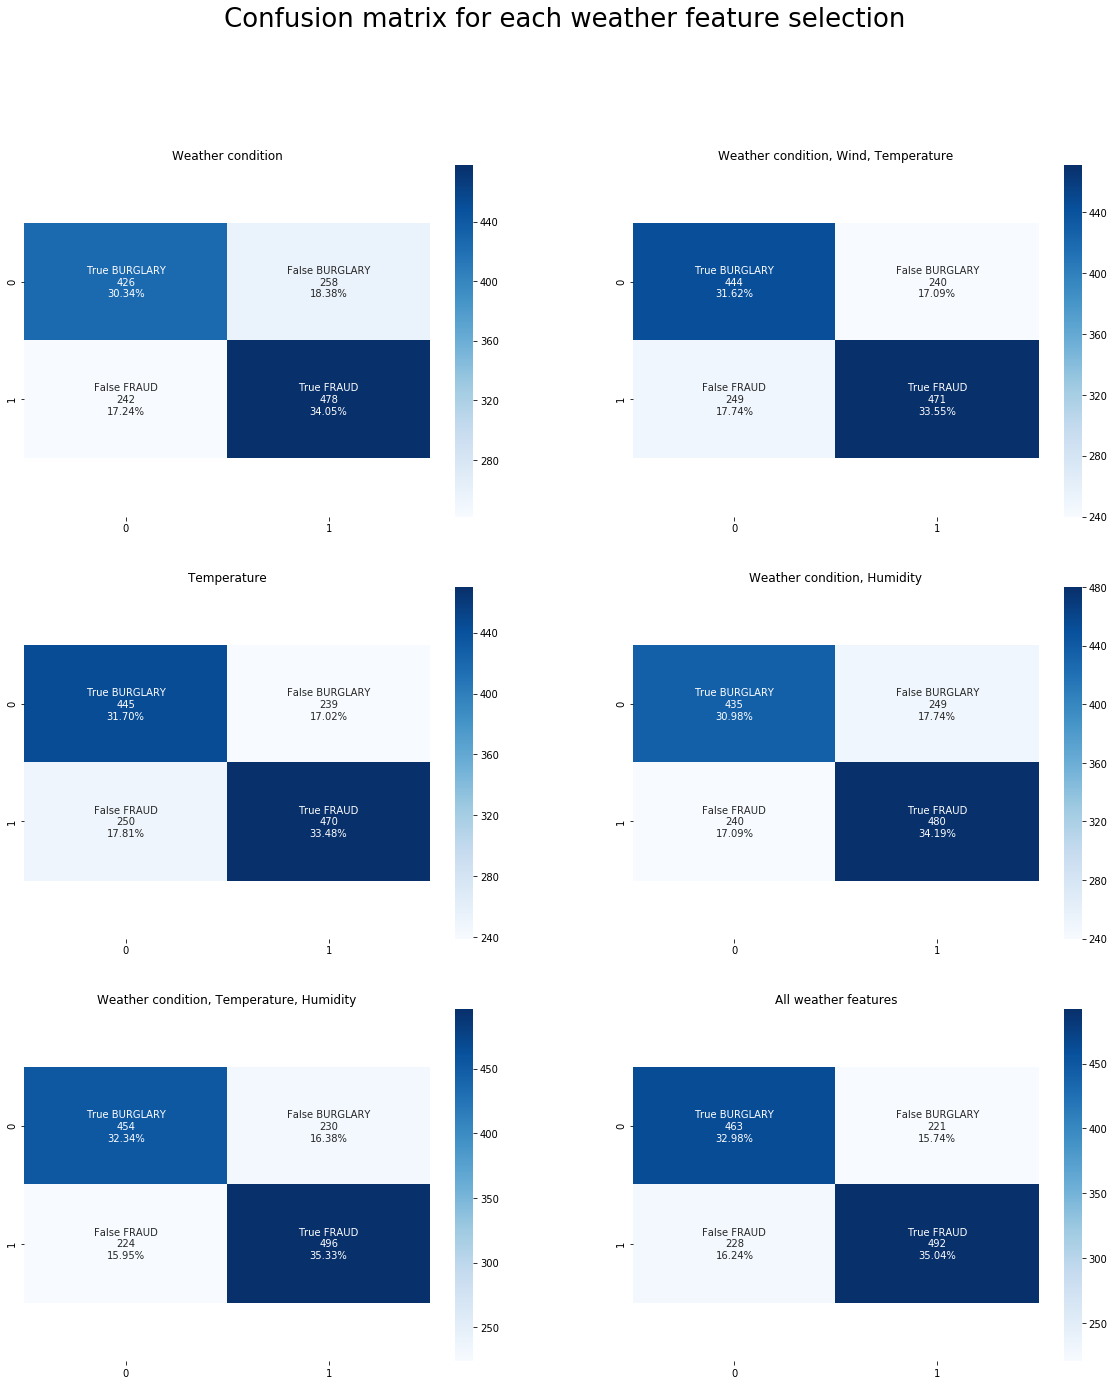

In [450]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,22))
fig.suptitle('Confusion matrix for each weather feature selection', fontsize=26)
predict_confusion_matrix(['Category','temperature', 'humidity', 'wind_speed','wind_direction', 'pressure'], crimeweather, crime1, crime2, ', '.join(['Weather condition']), ax=axes[0][0])
predict_confusion_matrix(['Category','humidity', 'pressure'], crimeweather, crime1, crime2, ', '.join(['Weather condition', 'Wind', 'Temperature']), ax=axes[0][1])
predict_confusion_matrix(['Category','humidity', 'wind_speed','wind_direction', 'pressure'] + list(weatherdummies.columns.values), crimeweather, crime1, crime2, ', '.join(['Temperature']), ax=axes[1][0])
predict_confusion_matrix(['Category','temperature', 'wind_speed','wind_direction', 'pressure'], crimeweather, crime1, crime2, ', '.join(['Weather condition', 'Humidity']), ax=axes[1][1])
predict_confusion_matrix(['Category','wind_speed','wind_direction', 'pressure'], crimeweather, crime1, crime2, ', '.join(['Weather condition', 'Temperature', 'Humidity']), ax=axes[2][0])
predict_confusion_matrix(['Category'], crimeweather, crime1, crime2, ', '.join(['All weather features']), ax=axes[2][1])
plt.show()

This evaluation of features shows that no matter what features are included, the classifier does predict FRAUD more precisely than it predicts BURGLARY. We find the highest and most balanced performance when including all the weather features and that is therefore our selected model.

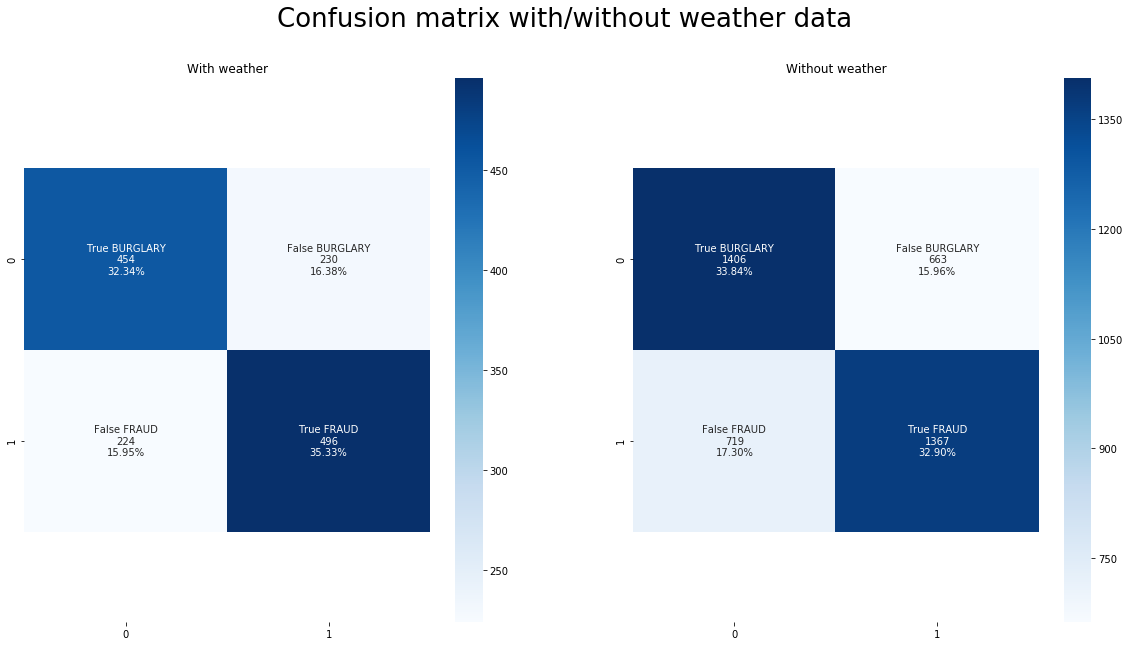

In [451]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.suptitle('Confusion matrix with/without weather data', fontsize=26)
predict_confusion_matrix(['Date', 'HourOfTheWeek', 'Category'], balanceddataset, crime1, crime2, "Without weather", ax=axes[1])
y_test, y_predict  = predict_confusion_matrix(['Category'], crimeweather, crime1, crime2, "With weather", ax=axes[0])

In [452]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.67      0.66      0.67       684
       FRAUD       0.68      0.69      0.69       720

    accuracy                           0.68      1404
   macro avg       0.68      0.68      0.68      1404
weighted avg       0.68      0.68      0.68      1404



The performance of the prediction including the weather data is slightly worse than the one without.
Our assumption was that FRAUD would not been predicted better using weather data given that there should no be a relationship between the two. On the other hand we expected BURGLARY to be highly affected by weather. Our best model including weather features show a worsening of the performance and a better prediction of the FRAUD crime. Exactly the opposite of what we expected.

The reason may lie in the significant reduction of the dataset size after the merging (due to some crime observations not having a corresponding row in the weather data). This could explain the general worsening of performances of the model.

The fact that FRAUD is better predicted than BURGLARY when including weather data could be explained by the higher number of FRAUD observations that were kept after the merging, as our plot for dataset size comparison shows. Having therefore an unbalanced dataset could have led to a better prediction of the most predonimant crime.

## Part 3: Data visualization

* Create the Bokeh visualization from Part 2 of the Week 8 Lecture, displayed in a beautiful `.gif` below. 
* Provide nice comments for your code. Don't just use the `# inline comments`, but the full Notebook markdown capabilities and explain what you're doing.

![Movie](https://github.com/suneman/socialdataanalysis2020/blob/master/files/week8_1.gif?raw=true "movie")